In [1]:
import matplotlib.pyplot as plt
from spacepy import pycdf
import numpy as np
import matplotlib.dates as mdates
import math
import datetime as dt
from datetime import datetime, timedelta
from matplotlib.axis import Axis
from matplotlib.pyplot import cm
from itertools import compress

class rpw_hfr_lab:
    
    def __init__(self, date, start_event, end_event, correct, filepath):
        self.date = date
        self.start_event = start_event
        self.end_event = end_event
        self.correct = correct
        self.filepath = filepath
    
    @staticmethod
    def array_dupes(a):
        u, c = np.unique(a, return_counts=True)
        dup = u[c > 1]
        return len(dup)
    @staticmethod
    def to_timestamp(array): # Converts datetime arrays into timestamp arrays
        timestamps = list(map(lambda x: datetime.timestamp(x), array))
        return timestamps
    @staticmethod
    def to_date(array): # Converts timestamp arrays into datetime arrays
        mydates = list(map(lambda x: datetime.fromtimestamp(x), array))
        return mydates
    @staticmethod
    def freq_chooser(a, m):
        choice = list(map(lambda x: len(x) == m, a))
        return choice
    @staticmethod
    def available_time(t, dt):
        return np.mod(t, dt)
    @staticmethod
    def join_sensors(x, y, n):
        x_non = np.where(x <= n)
        #y_non = np.where(y > n)
        x[x_non] = y[x_non]
        return x
    @staticmethod
    def caliber_func(s, f, t, v, n1, n2, n3):
        s1, t1, f1, v1 = s[np.where(s == n1)], t[np.where(s == n1)], f[np.where(s == n1)], v[np.where(s == n1)]
        s2, t2, f2, v2 = s[np.where(s == n2)], t[np.where(s == n2)], f[np.where(s == n2)], v[np.where(s == n2)]
        s3, t3, f3, v3 = s[np.where(s == n3)], t[np.where(s == n3)], f[np.where(s == n3)], v[np.where(s == n3)]
        
        if n1 == 9:
            f[np.where(s == n2)] = f[np.where(s == n2)] * (-5.6e-5 * v2 + 1.82)
            f[np.where(s == n3)] = f[np.where(s == n3)] * (-2.5e-6 * v3 + 0.96)
        elif n1 == 10:
            f[np.where(s == n2)] = f[np.where(s == n2)] / (-5.6e-5 * v2 + 1.82)
            f[np.where(s == n3)] = f[np.where(s == n3)] * (-1.5e-5 * v3 + 0.52)
        elif n1 == 11:
            f[np.where(s == n2)] = f[np.where(s == n2)] / (-2.5e-6 * v2 + 0.96)
            f[np.where(s == n3)] = f[np.where(s == n3)] / (-1.5e-5 * v3 + 0.52)
        
        return f
    def header(self):
        head_txt = """
        Import the following modules:
        
        import matplotlib.pyplot as plt
        from spacepy import pycdf
        import numpy as np
        import matplotlib.dates as mdates
        import math
        import datetime as dt
        from datetime import datetime
        from matplotlib.axis import Axis
        from matplotlib.pyplot import cm
        from itertools import compress
        
        Example:
        my_data = rpw_hfr_lab('2021-10-28', '00:00:00', '20:00:00', 'RPW_plotting\\solo_L2_rpw-hfr-surv-cdag_20211028_V05')
        
        my_data.data()['frequencies']
        >>> frequency array in kHz
        my_data.data()['time']
        >>> time array
        my_data.data()['l2_spectrum']
        >>> dynamic spectrum in V^2/Hz
        
        my_data.plot("hfr_dynamic_spectrum\\non_cal\\")
        >>> plots the dynamic spectrum in dB and saves it as 'hfr_dynspec_noncal_date.png' in the path you indicate
        
        my_data.light(875)
        >>> plots the bakground subtracted lightcurve (V^2/Hz) for 875 kHz frequency
        """
        print(head_txt)
    
    def data(self):
        
        cdf_file = pycdf.CDF(self.filepath)
        
        freq_, epoch_, AGC__, sensor_ = cdf_file['FREQUENCY'][...], cdf_file['Epoch'][...], self.join_sensors(cdf_file['AGC1'][...], cdf_file['AGC2'][...], 0), self.join_sensors(cdf_file['SENSOR_CONFIG'][0:-1,0], cdf_file['SENSOR_CONFIG'][0:-1,1], 8)
        if self.correct == 'smooth':
            sensor_values = np.array([9, 10, 11])
            condition = np.where((sensor_==9)|(sensor_==10)|(sensor_==11))
            freq, epoch, AGC_, sensor = freq_[condition], epoch_[condition], AGC__[condition], sensor_[condition]
            sensor_counts = np.argmax(np.bincount(sensor))
            s1 = sensor_values[np.where(sensor_values == sensor_counts)]
            s23 = sensor_values[np.where(sensor_values != sensor_counts)]
            AGC = self.caliber_func(np.array(sensor), np.array(AGC_), np.array(self.to_timestamp(epoch)), np.array(freq), s1[0], s23[0], s23[1])
        elif self.correct == 'rough':
            sensor_counts = np.argmax(np.bincount(sensor_[np.where((sensor_==9)|(sensor_==10)|(sensor_==11))]))
            condit = np.where(sensor_==sensor_counts)
            freq, epoch, AGC, sensor = freq_[condit], epoch_[condit], AGC__[condit], sensor_[condit]
            
        freq_num = self.array_dupes(freq)
        freq_list = freq[0:freq_num]
        freq_choice_ = list(map(lambda x: list(np.array(np.where(freq==x)[0])), freq_list))
        
        max_len = np.max(list(map(lambda x: len(x), freq_choice_)))
        freq_choice = list(compress(freq_choice_,self.freq_chooser(freq_choice_, max_len)))
        frequencies = list(compress(freq_list, self.freq_chooser(freq_choice_, max_len)))
        freq_num = len(frequencies)
        # For each frequency, apply same indexes to time and flux
        epoch_choice = epoch[freq_choice]
        AGC_choice = AGC[freq_choice]

        yyyy, mm, dd = self.date.split('-')
        HH_s, MM_s, SS_s = self.start_event.split(':')
        HH_e, MM_e, SS_e = self.end_event.split(':')
        time_start = dt.datetime(int(yyyy), int(mm), int(dd), int(HH_s), int(MM_s), int(SS_s))
        time_end = dt.datetime(int(yyyy), int(mm), int(dd), int(HH_e), int(MM_e), int(SS_e))

        def time_inter(t_arr):
            start = np.abs(np.array(self.to_timestamp(t_arr))-datetime.timestamp(time_start)).argmin()
            end = np.abs(np.array(self.to_timestamp(t_arr))-datetime.timestamp(time_end)).argmin()
            return [start, end]

        middle_freq = math.ceil(len(frequencies)/2.)
        start = time_inter(epoch_choice[middle_freq])[0]
        end = time_inter(epoch_choice[middle_freq])[1]

        epoch_choice_plot = epoch_choice[:, start:end]
        AGC_choice_plot = AGC_choice[:, start:end]
        middle_freq = math.ceil(len(frequencies)/2.)
        
        def ten_min_cal(t, f):
            f_max = np.argmax(f[start:end])
            t_max = t[start:end]
            m = np.where(t == t_max[f_max])
            di = t[m[0]]-timedelta(minutes = 50)
            df = t[m[0]]-timedelta(minutes = 40)
            i = np.abs(np.array(self.to_timestamp(t))- datetime.timestamp(di[0])).argmin()
            j = np.abs(np.array(self.to_timestamp(t))- datetime.timestamp(df[0])).argmin()
            c = np.median(f[i:j])
            return c

        def ten_min_cal_plus(t, f):
            f_max = np.argmax(f[start:end])
            t_max = t[start:end]
            m = np.where(t == t_max[f_max])
            di = t[m[0]]+timedelta(minutes = 20)
            df = t[m[0]]+timedelta(minutes = 30)
            i = np.abs(np.array(self.to_timestamp(t))- datetime.timestamp(di[0])).argmin()
            j = np.abs(np.array(self.to_timestamp(t))- datetime.timestamp(df[0])).argmin()
            c = np.median(f[i:j])
            return c

        Spectro = []

        for i in list(range(0, freq_num)):
            order = np.argsort(self.to_timestamp(epoch_choice_plot[i]))
            if int(HH_s)<1:
                AGC_specter = np.interp(np.sort(self.to_timestamp(epoch_choice_plot[middle_freq])), self.to_timestamp(epoch_choice_plot[i]), AGC_choice_plot[i]) - ten_min_cal_plus(epoch_choice[i], AGC_choice[i])
                AGC_specter[AGC_specter <= 0] = ten_min_cal_plus(epoch_choice[i], AGC_choice[i])
            else:
                AGC_specter = np.interp(np.sort(self.to_timestamp(epoch_choice_plot[middle_freq])), self.to_timestamp(epoch_choice_plot[i]), AGC_choice_plot[i]) - ten_min_cal(epoch_choice[i], AGC_choice[i])
                AGC_specter[AGC_specter <= 0] = ten_min_cal(epoch_choice[i], AGC_choice[i])
            Spectro.append(list(AGC_specter))
        data_dict = {'time': self.to_date(np.sort(self.to_timestamp(epoch_choice_plot[middle_freq]))), 'frequencies': np.array(frequencies), 'l2_spectrum': Spectro}

        return data_dict
    
    def light(self, frequency):
        
        dic_to_plot = rpw_hfr_lab(self.date, self.start_event, self.end_event, self.correct, self.filepath).data()
        time_arr, freq_arr, Spectro = dic_to_plot['time'], dic_to_plot['frequencies'], dic_to_plot['l2_spectrum']
        
        HH_s, MM_s, SS_s = self.start_event.split(':')
        HH_e, MM_e, SS_e = self.end_event.split(':')
        
        fig = plt.figure(figsize=(15,8))
        ax_grid = fig.add_gridspec(1, 1)
        ax_ = ax_grid[0].subgridspec(1, 1, hspace=0.005)
        ax = [fig.add_subplot(ax_[0, 0])]
        myFmt = mdates.DateFormatter('%H:%M')
        
        i = list(freq_arr).index(875)
        lbl = freq_arr[i]
        
        ax[0].plot(time_arr, Spectro[i], label=str(lbl) + ' kHz', linewidth=2, c='k')

        for a in ax:
            a.xaxis.set_major_formatter(myFmt)
            a.tick_params(axis='both', which='both', labelsize=20, length=7, width=2)
        ax[0].set_ylabel('Flux (V$^2$/Hz)', fontsize=20)
        ax[0].set_xlabel('Time (HH:MM)', fontsize=20)
        ax[0].set_yscale("log")
        ax[0].set_ylim(np.min(Spectro[i]), 1.5*np.max(Spectro[i]))
        ax[0].set_title(self.date + ' (yyyy-mm-dd)', fontsize=20)
        ax[0].legend(loc='upper right', fontsize = 20, frameon=False)
    
    def plot(self, fig_path):
        
        dic_to_plot = rpw_hfr_lab(self.date, self.start_event, self.end_event, self.correct, self.filepath).data()
        time_arr, freq_arr, Spectro = dic_to_plot['time'], dic_to_plot['frequencies'], dic_to_plot['l2_spectrum']
        
        HH_s, MM_s, SS_s = self.start_event.split(':')
        HH_e, MM_e, SS_e = self.end_event.split(':')
        
        myFmt = mdates.DateFormatter('%H:%M')
        fig = plt.figure(figsize=(15,7))
        ax_spectro = fig.add_subplot(111)
        Spectrum = 10*np.log10(Spectro)
        #v_min_val, v_max_val =np.log10(np.min(Spectro)) + 10, 10*np.log10((np.max(Spectro) + np.min(Spectro))/2)
        v_min_val, v_max_val = np.min(Spectrum) + 50, 10*np.log10((np.max(Spectro) + np.min(Spectro))/2.)
        T,F = np.meshgrid(time_arr, freq_arr)
        #im = ax_spectro.pcolormesh(T, F, Spectro, cmap=cm.inferno, vmin=v_min_val , vmax=v_max_val)
        im = ax_spectro.pcolormesh(T, F, Spectrum, cmap=cm.inferno, vmin=v_min_val , vmax=v_max_val)
        cbar = fig.colorbar(im)
        cbar.ax.tick_params(labelsize=15)
        cbar.set_label('dB', fontsize=20)
        ax_spectro.xaxis.set_major_formatter(myFmt)
        ax_spectro.tick_params(axis='both', which='both', labelsize=15, length=5, width=1)
        ax_spectro.set_yscale("log")
        ax_spectro.set_xlabel('Time (HH:MM)', fontsize=20)
        ax_spectro.set_ylabel('Frequency (kHz)', fontsize=20)
        ax_spectro.set_title(self.date + ' (yyyy-mm-dd)', fontsize=20)
        plt.savefig(fig_path + "hfr_dynspec_" + self.correct + '_' + self.date + '_' + HH_s + '_' + HH_e + ".png", bbox_inches='tight')

C:\Users\franc\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\franc\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
C:\Users\franc\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
result = rpw_hfr_lab('2021-10-28', '15:00:00', '16:00:00', 'smooth', 'RPW_plotting\\solo_L2_rpw-hfr-surv-cdag_20211028_V05')

In [3]:
result.header()


        Import the following modules:
        
        import matplotlib.pyplot as plt
        from spacepy import pycdf
        import numpy as np
        import matplotlib.dates as mdates
        import math
        import datetime as dt
        from datetime import datetime
        from matplotlib.axis import Axis
        from matplotlib.pyplot import cm
        from itertools import compress
        
        Example:
        my_data = rpw_hfr_lab('2021-10-28', '00:00:00', '20:00:00', 'RPW_plotting\solo_L2_rpw-hfr-surv-cdag_20211028_V05')
        
        my_data.data()['frequencies']
        >>> frequency array in kHz
        my_data.data()['time']
        >>> time array
        my_data.data()['l2_spectrum']
        >>> dynamic spectrum in V^2/Hz
        
        my_data.plot("hfr_dynamic_spectrum\non_cal\")
        >>> plots the dynamic spectrum in dB and saves it as 'hfr_dynspec_noncal_date.png' in the path you indicate
        
        my_data.light(875)
        >>> plots the b

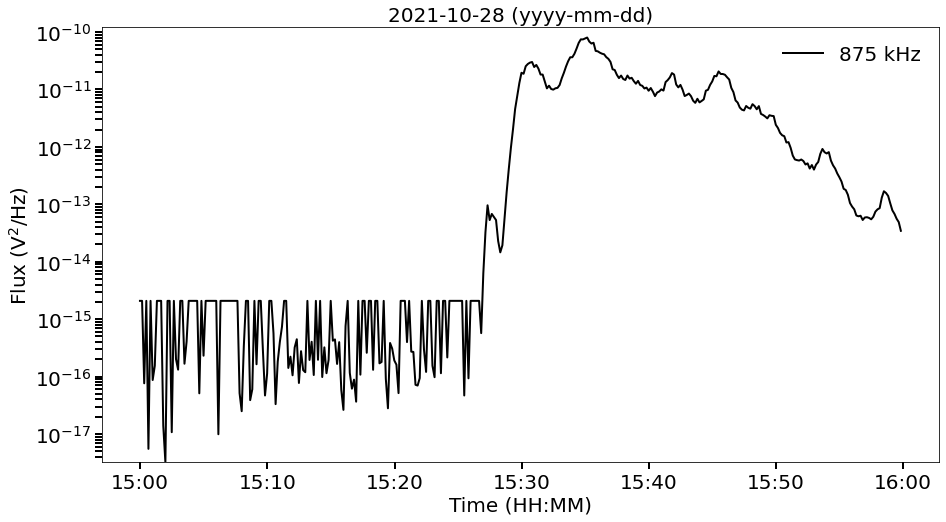

In [4]:
result.light(875)

In [ ]:
result.plot("hfr_dynamic_spectrum\\non_cal\\")